# Organizational Analysis Pipeline Demo

This notebook demonstrates the complete pipeline:
1. Generate organizational hidden state
2. Encode to narrative summary (optional)
3. Generate forward forecast


## Setup

Import required libraries and set up the environment.



--- Visualizing Collaboration Graph ---


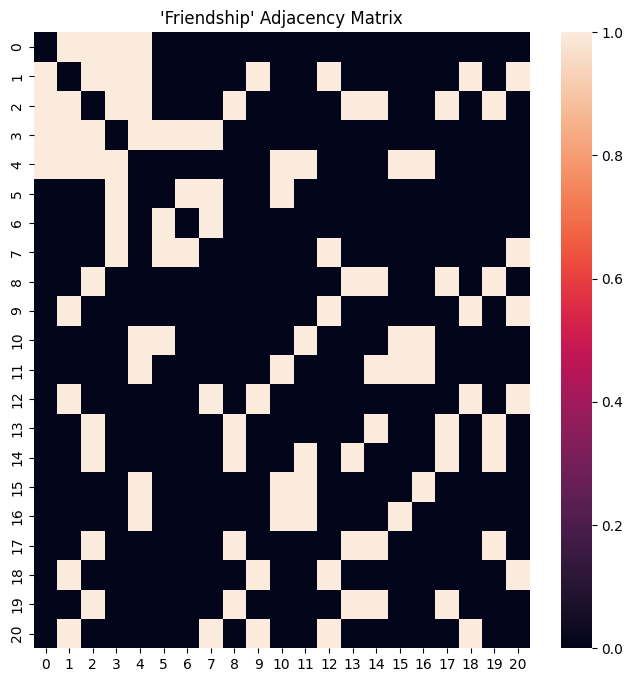

✓ Imports successful
✓ Environment loaded
✓ Reloaded forward_forecaster module (cleared cache)


In [1]:
import json
import os
from pathlib import Path
import pandas as pd
import numpy as np

# Load environment variables (for OpenAI API key)
from dotenv import load_dotenv
load_dotenv()

# Import pipeline modules
from hidden_state_generation import (
    sample_org_seed,
    sample_rec_seed,
    sample_situation_seed,
    OrganizationHiddenState
)
from encoder_layer import encode_hidden_state_to_text
from forward_forecaster import forecast_scenario, forecast_from_file

# Set random seed for reproducibility
np.random.seed(42)

print("✓ Imports successful")
print("✓ Environment loaded")

# Force reload forward_forecaster to clear any cached versions
import importlib
import sys
if 'forward_forecaster' in sys.modules:
    importlib.reload(sys.modules['forward_forecaster'])
    # Re-import to get the fresh version
    from forward_forecaster import forecast_scenario, forecast_from_file
    print("✓ Reloaded forward_forecaster module (cleared cache)")


## Step 1: Generate Hidden Organizational State

Create a synthetic organizational structure with employees, relationships, and context.


In [2]:
# Sample seeds for organization, recommendation, and situation
org_seed = sample_org_seed(seed=123)
rec_seed = sample_rec_seed(seed=456)
sit_seed = sample_situation_seed(seed=789)

print("Generated Seeds:")
print(f"  Organization: {org_seed}")
print(f"  Recommendation: {rec_seed}")
print(f"  Situation: {sit_seed}")


Generated Seeds:
  Organization: {'industry_id': 0, 'size_id': 2, 'power_distance': 0.053821018802222675, 'sanction_salience': 0.22035987277261138, 'in_group_bias': 0.1843718106986697}
  Recommendation: {'domain_id': 2, 'theta_ideal': 0.44765529815712257, 'urgency': 0.12405680609965541, 'resource_need': 0.7548499814761097}
  Situation: {'theta_current': 0.09159673646522415, 'visibility_flag': 0, 'sanction_strength': 0.6318460965633647, 'provocation_flag': 0}


In [3]:
# Generate the full organizational hidden state
hidden_state = OrganizationHiddenState(
    org_seed=org_seed,
    rec_seed=rec_seed,
    situation_seed=sit_seed,
    departments=['Engineering', 'Marketing', 'Sales', 'HR'],
    avg_span_of_control=5
)

print(f"✓ Generated organization with {hidden_state.N} employees")
print(f"\nEmployee Levels:")
for level, count in hidden_state.levels.items():
    print(f"  {level}: {count}")

print(f"\nDepartments:")
dept_counts = hidden_state.employees['department'].value_counts()
for dept, count in dept_counts.items():
    print(f"  {dept}: {count}")


✓ Generated organization with 22 employees

Employee Levels:
  C-Suite: 1
  Director: 4
  Manager: 17

Departments:
  Engineering: 10
  Sales: 6
  Marketing: 5
  HR: 1


In [4]:
# Convert to JSON and save
json_output = hidden_state.to_json_encoding()
hidden_state_dict = json.loads(json_output)

# Save to file
os.makedirs("sample_hidden_states", exist_ok=True)
hidden_state_path = "sample_hidden_states/demo_state.json"
with open(hidden_state_path, "w") as f:
    f.write(json_output)

print(f"✓ Saved hidden state to {hidden_state_path}")
print(f"\nState Summary:")
print(f"  Employees: {hidden_state_dict['num_employees']}")
print(f"  Industry: {hidden_state_dict['org_seed']['industry']}")
print(f"  Size: {hidden_state_dict['org_seed']['size']}")
print(f"  Recommendation Domain: {hidden_state_dict['rec_seed']['domain']}")
print(f"  Graphs: {list(hidden_state_dict['graphs'].keys())}")


✓ Saved hidden state to sample_hidden_states/demo_state.json

State Summary:
  Employees: 22
  Industry: tech
  Size: large
  Recommendation Domain: budget
  Graphs: ['reports_to', 'collaboration', 'friendship', 'influence', 'conflict']


In [ ]:
# Display employee roster
print("Employee Roster:")
print(hidden_state.employees.to_string())


## Step 2: Encode to Narrative Summary (Optional)

Convert the structured hidden state into a narrative summary using GPT. This step is optional but can provide useful context.


In [ ]:
# Encode hidden state to narrative
print("Encoding hidden state to narrative...")
narrative_json = encode_hidden_state_to_text(hidden_state_path)

if narrative_json.startswith("Error"):
    print(f"⚠ {narrative_json}")
    print("Skipping encoding step. Continuing with raw hidden state...")
    narrative_data = None
else:
    narrative_data = json.loads(narrative_json)
    
    # Save encoded output
    os.makedirs("sample_encoder_input", exist_ok=True)
    encoded_path = "sample_encoder_input/demo_encoded.json"
    with open(encoded_path, "w") as f:
        f.write(narrative_json)
    
    print(f"✓ Saved encoded narrative to {encoded_path}")
    print("\nNarrative Summary:")
    print(f"\nCompany Description:\n{narrative_data['company_description'][:200]}...")
    print(f"\nKey Relationships:\n{narrative_data['key_relationships'][:200]}...")
    print(f"\nRecommendation Context:\n{narrative_data['recommendation_context'][:200]}...")


## Step 3: Generate Forward Forecast

Use the hidden state to generate a deterministic forecast of organizational response using GPT with structured outputs.


In [ ]:
# Generate forecast from hidden state
print("Generating forward forecast...")
print("(Using OpenAI Structured Outputs with deterministic temperature=0)\n")

forecast = forecast_scenario(
    hidden_state=hidden_state_dict,
    scenario_id="demo_scenario",
    model="gpt-4o-mini",
    prompt_template_id="v3",
    horizon="decision"
)

if "error" in forecast and forecast.get("error"):
    print(f"❌ Error: {forecast.get('error_message', 'Unknown error')}")
    print("\nNote: The forecast generation failed.")
    print("This may be due to API issues, rate limits, or validation errors.")
else:
    print("✓ Forecast generated successfully")
    print(f"  - {len(forecast.get('individual_sentiments', []))} individual sentiment predictions")
    if "segments" in forecast:
        dept_count = len(forecast.get('segments', {}).get('by_department', {}))
        level_count = len(forecast.get('segments', {}).get('by_level', {}))
        print(f"  - {dept_count} departments, {level_count} levels analyzed")
    if "features_importance" in forecast:
        print(f"  - {len(forecast.get('features_importance', []))} features analyzed")
    if "rationale" in forecast:
        print(f"  - Rationale generated ({len(forecast['rationale'])} chars)")


In [ ]:
# Display forecast results
if "error" not in forecast or not forecast.get("error"):
    print("=" * 80)
    print("FORECAST RESULTS - SENTIMENT PROPAGATION")
    print("=" * 80)
    
    print(f"\nScenario ID: {forecast['scenario_id']}")
    print(f"State Hash: {forecast['state_hash']}")
    print(f"Horizon: {forecast['horizon']}")
    print(f"Model: {forecast['model']['model']} (temp={forecast['model']['temperature']})")
    
    # Display aggregate outcomes
    if "aggregate_outcomes" in forecast:
        print("\n" + "-" * 80)
        print("AGGREGATE OUTCOMES")
        print("-" * 80)
        
        agg = forecast['aggregate_outcomes']
        top_class = agg['top_class']
        top_prob = agg['probabilities'][top_class]
        print(f"\nTop Class: {top_class.upper()}")
        print(f"Top Probability: {top_prob:.1%}")
        
        print("\nProbabilities:")
        for cls, prob in agg['probabilities'].items():
            bar_length = int(prob * 50)
            bar = "█" * bar_length + "░" * (50 - bar_length)
            print(f"  {cls:10s}: {prob:6.1%} {bar}")
        
        total = sum(agg['probabilities'].values())
        print(f"\n  Total: {total:.6f} {'✓' if abs(total - 1.0) < 1e-6 else '✗'}")
    
    # Display individual sentiments
    if "individual_sentiments" in forecast:
        print("\n" + "-" * 80)
        print("INDIVIDUAL SENTIMENT PROPAGATION")
        print("-" * 80)
        
        sentiments = forecast['individual_sentiments']
        print(f"\nTotal Employees: {len(sentiments)}")
        
        # Count by sentiment
        sentiment_counts = {}
        for s in sentiments:
            sent = s.get("sentiment", "unknown")
            sentiment_counts[sent] = sentiment_counts.get(sent, 0) + 1
        
        print(f"\nSentiment Distribution:")
        for sent, count in sorted(sentiment_counts.items()):
            pct = count / len(sentiments) * 100
            print(f"  {sent:10s}: {count:3d} employees ({pct:5.1f}%)")
        
        # Show detailed examples
        print(f"\nDetailed Individual Predictions (first 10):")
        for s in sentiments[:10]:
            emp_id = s.get("employee_id", "?")
            sent = s.get("sentiment", "?")
            prob = s.get("probabilities", {}).get(sent, 0)
            influences = s.get("influence_sources", [])
            path = s.get("propagation_path", [])
            
            print(f"\n  Employee {emp_id}: {sent.upper()} (prob: {prob:.2f})")
            if influences:
                print(f"    Influenced by {len(influences)} sources:")
                for inf in influences[:3]:  # Show first 3
                    print(f"      - Employee {inf['employee_id']} via {inf['graph_type']} (weight: {inf['influence_weight']:.2f})")
                if len(influences) > 3:
                    print(f"      ... and {len(influences) - 3} more")
            if path:
                print(f"    Propagation path: {' → '.join(map(str, path))}")


In [ ]:
# Display segment analysis if available
if "error" not in forecast or not forecast.get("error"):
    if "segments" in forecast:
        print("\n" + "-" * 80)
        print("SEGMENT ANALYSIS")
        print("-" * 80)
        
        segments = forecast['segments']
        
        if "by_department" in segments:
            print("\nBy Department:")
            for dept, probs in segments["by_department"].items():
                top = max(probs.items(), key=lambda x: x[1])
                print(f"  {dept:15s}: {top[0]:10s} ({top[1]:.1%})")
        
        if "by_level" in segments:
            print("\nBy Level:")
            for level, probs in segments["by_level"].items():
                top = max(probs.items(), key=lambda x: x[1])
                print(f"  {level:15s}: {top[0]:10s} ({top[1]:.1%})")


In [ ]:
# Display rationale and insights
if "error" not in forecast or not forecast.get("error"):
    print("\n" + "-" * 80)
    print("RATIONALE & INSIGHTS")
    print("-" * 80)
    
    if "rationale" in forecast:
        print(f"\nRationale:\n{forecast['rationale']}")
    
    if "features_importance" in forecast and forecast["features_importance"]:
        print("\nKey Features:")
        for feature in forecast["features_importance"][:5]:
            direction_symbol = "↑" if feature["direction"] == "+" else "↓"
            print(f"  {direction_symbol} {feature['feature']:30s} (weight: {feature['weight']:.2f})")
    
    if "constraints_used" in forecast and forecast["constraints_used"]:
        print("\nConstraints:")
        for constraint in forecast["constraints_used"]:
            print(f"  • {constraint}")
    
    if "warnings" in forecast and forecast["warnings"]:
        print("\nWarnings:")
        for warning in forecast["warnings"]:
            print(f"  ⚠ {warning}")


In [ ]:
# Save forecast to file
# Save even if there's an error, so we can inspect what was generated
os.makedirs("sample_forecasts", exist_ok=True)
forecast_path = "sample_forecasts/demo_forecast.json"
with open(forecast_path, "w") as f:
    json.dump(forecast, f, indent=2)

print(f"\n✓ Saved forecast to {forecast_path}")
if "error" in forecast and forecast.get("error"):
    print(f"⚠ Note: Forecast has validation errors - see 'error_message' field")


## Summary

The pipeline has completed successfully:

1. ✅ Generated organizational hidden state
2. ✅ Encoded to narrative (if API available)
3. ✅ Generated forward forecast

### Files Generated:
- `sample_hidden_states/demo_state.json` - Raw organizational state
- `sample_encoder_input/demo_encoded.json` - Narrative summary (if encoding succeeded)
- `sample_forecasts/demo_forecast.json` - Forecast results


In [ ]:
# Display key forecast statistics
print("\n" + "=" * 80)
print("FORECAST SUMMARY")
print("=" * 80)

if "error" in forecast and forecast.get("error"):
    print(f"\n❌ Error: {forecast.get('error_message', 'Unknown error')}")
else:
    print("\n✓ Forecast generated successfully")
    
    print(f"\nKey Statistics:")
    print(f"  - Individual Sentiments: {len(forecast.get('individual_sentiments', []))}")
    
    if "segments" in forecast:
        dept_count = len(forecast.get('segments', {}).get('by_department', {}))
        level_count = len(forecast.get('segments', {}).get('by_level', {}))
        print(f"  - Departments: {dept_count}")
        print(f"  - Levels: {level_count}")
    
    if "features_importance" in forecast:
        print(f"  - Features Analyzed: {len(forecast.get('features_importance', []))}")
    
    if forecast.get('aggregate_outcomes'):
        top_class = forecast['aggregate_outcomes'].get('top_class', 'unknown')
        top_prob = forecast['aggregate_outcomes'].get('probabilities', {}).get(top_class, 0)
        print(f"\n  Aggregate Top Class: {top_class.upper()} ({top_prob:.1%})")
    
    print(f"\n  Model: {forecast.get('model', {}).get('model', 'unknown')} (temp={forecast.get('model', {}).get('temperature', 'unknown')})")
    print(f"  State Hash: {forecast.get('state_hash', 'unknown')[:20]}...")

# Optionally display full JSON (commented out to avoid clutter)
# print("\nFull Forecast JSON:")
# print(json.dumps(forecast, indent=2))
